# Create a monochrome version of MNIST 
by spliting the MNIST into 4 subsets

Change the background (or digit's whitespace?) color to 
- keep as is (Black)
- Red
- Green
- Blue

The resulting dataset will consists of 4 subdatasets each of which has its own "style" (ie. the color of the background).


## Load libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os,sys
import re
import math
from datetime import datetime
import time
sys.dont_write_bytecode = True

In [3]:
import pandas as pd

import numpy as np
import joblib
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Any, List, Set, Dict, Tuple, Optional, Iterable, Mapping, Union, Callable, TypeVar

from pprint import pprint
from ipdb import set_trace as brpt

In [4]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torch.linalg import norm as tnorm
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.tuner.tuning import Tuner


# Select Visible GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Set Path 
1. Add project root and src folders to `sys.path`
2. Set DATA_ROOT to `maptile_v2` folder

In [5]:
this_nb_path = Path(os.getcwd())
ROOT = this_nb_path.parent
SRC = ROOT/'src'
DATA_ROOT = Path("/data/hayley-old/maptiles_v2/")
paths2add = [this_nb_path, ROOT]

print("Project root: ", str(ROOT))
print('Src folder: ', str(SRC))
print("This nb path: ", str(this_nb_path))


for p in paths2add:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(f"\n{str(p)} added to the path.")
# print(sys.path)

Project root:  /data/hayley-old/Tenanbaum2000
Src folder:  /data/hayley-old/Tenanbaum2000/src
This nb path:  /data/hayley-old/Tenanbaum2000/nbs

/data/hayley-old/Tenanbaum2000 added to the path.


In [6]:
from src.data.datamodules.maptiles_datamodule import MaptilesDataModule

from src.data.transforms.transforms import Identity, Unnormalizer, LinearRescaler, Monochromizer
from src.data.transforms.functional import unnormalize, to_monochrome

from src.visualize.utils import show_timg, show_timgs, show_batch, make_grid_from_tensors
from src.utils.misc import info
from collections import OrderedDict, defaultdict
from PIL import Image

---
## Test MonoMNIST dataset
Jan 5, 2021

In [7]:
from src.data.datasets.mono_mnist import MonoMNIST

In [12]:
GrayMNIST = MonoMNIST(data_root=ROOT/'data/Mono-MNIST',
                      color='gray',
                      train=True)

RedMNIST = MonoMNIST(data_root=ROOT/'data/Mono-MNIST',
                    color='red',
                    train=True)
GreenMNIST = MonoMNIST(data_root=ROOT/'data/Mono-MNIST',
                    color='green',
                      train=True)
BlueMNIST = MonoMNIST(data_root=ROOT/'data/Mono-MNIST',
                    color='blue',
                     train=True)

train_mnist_gray_seed-123 15015


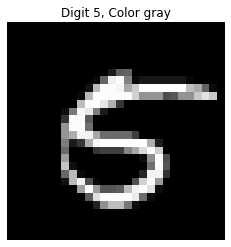

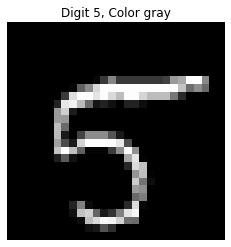

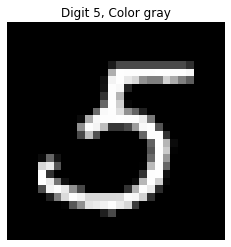

train_mnist_red_seed-123 14995


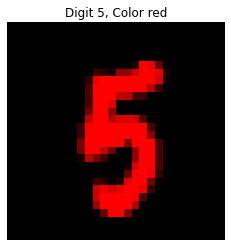

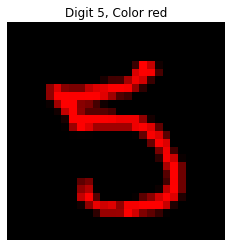

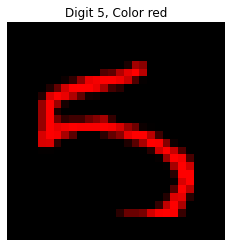

train_mnist_green_seed-123 14995


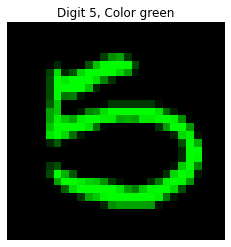

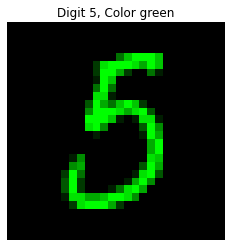

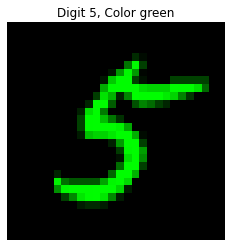

train_mnist_blue_seed-123 14995


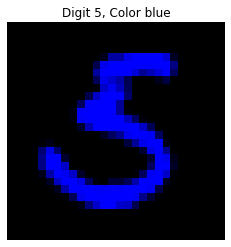

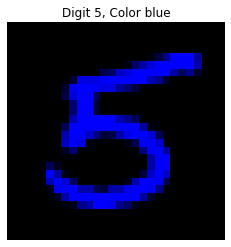

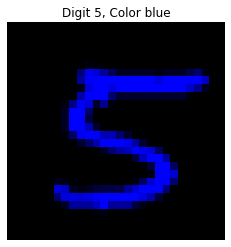

In [14]:
for ds in [GrayMNIST, RedMNIST, GreenMNIST, BlueMNIST]:
    print(ds.name, len(ds))
    for i in range(3):
        batch = ds[i]
        x,y,d = ds.unpack(batch)
        show_timg(x)
        plt.title(f"Digit {y}, Color {d}")
        plt.show()

In [16]:
ds = RedMNIST
dl = DataLoader(ds)

In [17]:
batch = next(iter(dl))
x,y,d = ds.unpack(batch)
x.shape, y.shape

(torch.Size([1, 3, 28, 28]), torch.Size([1]))

---

## Test MonoDatamodule for each color

In [18]:
from src.data.datamodules import MonoMNISTDataModule
in_shape = (3,32,32)
batch_size=16
color = 'red'

dm = MonoMNISTDataModule(
    data_root=Path('/data/hayley-old/Tenanbaum2000/data/Mono-MNIST/'),
    color=color,
    seed=123,
    in_shape=in_shape,
    batch_size=batch_size
)

In [19]:
dm.setup('fit')


In [20]:
dm.n_train, dm.n_val


(10496, 4499)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


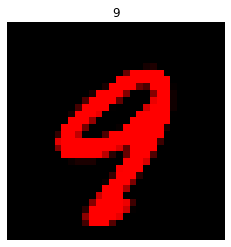

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


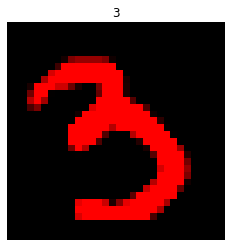

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


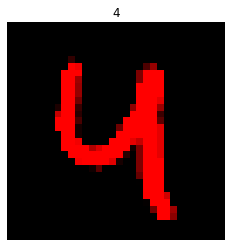

In [23]:
ds = dm.val_ds
for i in range(3):
    batch = ds[i]
    x,y,d = MonoMNIST.unpack(batch)
    show_timg(x)
    plt.title(y)
    plt.show()
    

In [24]:
batch = next(iter(dm.train_dataloader()))
x,y,d = MonoMNIST.unpack(batch)
x.shape, y.shape

(torch.Size([16, 3, 32, 32]), torch.Size([16]))

In [ ]:
a

In [ ]:
show_timgs(x)

In [25]:
for color in ['gray', 'red', 'green', 'blue']:
    dm = MonoMNISTDataModule(
        data_root=Path('/data/hayley-old/Tenanbaum2000/data/Mono-MNIST/'),
        color=color,
        seed=123,
        in_shape=in_shape,
        batch_size=batch_size
    )
    dm.setup('fit')
#     show_batch(dm, cmap='gray' if color=='gray' else None) 
#     plt.show()

---
- Can I append a new `transform` (Callable) to a list of `transform`s wrapped in `transform.Compose`?
  - Yes: use `transforms.Compose` again and pass in the composed transform as one
  of the inputs to the function


In [ ]:
xform = transforms.Compose([
transforms.ToTensor()])


In [ ]:
# xform.append(transforms.CenterCrop(10))

In [ ]:
xform = transforms.Compose([transforms.ToTensor()])


In [ ]:
xform2 = transforms.Compose([
    xform,
    transforms.CenterCrop(10)
])

In [ ]:
xform2


In [ ]:
datasets = []
for i in range(3):
    datasets.append(TensorDataset(torch.arange(i*10, (i+1)*10)))

dataset = ConcatDataset(datasets)
loader = DataLoader(
    dataset,
    shuffle=False,
    num_workers=0,
    batch_size=2
)

for data in loader:
    print(data)